# Q2. Neural Networks

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

(a) Custom Neural Network

In [6]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - s.T@s

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))

def cross_entropy_loss(p, q, eps=1e-12):
    m = p.shape[0]
    loss = -np.sum(p * np.log(q + eps)) / m
    return loss

def cross_entropy_grad_netk(p, q):
    # because p[k] = 1 iff k is true label
    return q - p

In [3]:
# TODO: check error derivative
# DOne: checked init (not fine)

In [7]:
class ANN:
    def __init__(self, n: int, hidden_size: list, r: int):
        self.input_size = n
        self.hidden_size = hidden_size
        self.output_size = r

        # TODO: try Xavier init

        # list of inter-layer weights : 
        std_init = np.sqrt(2/(n + hidden_size[0]))
        self.weights = [np.random.normal(0, std_init, size=(n, hidden_size[0]))]
        # self.weights = [np.random.randn(n, hidden_size[0])]   # init=randn

        # list of inter-layer biases : init=0
        self.biases = [np.zeros((1,hidden_size[0]))]

        for i in range(1,len(hidden_size)):
            std_init = np.sqrt(2/(hidden_size[i-1] + hidden_size[i]))
            self.weights.append(np.random.normal(0, std_init, size=(hidden_size[i-1], hidden_size[i])))
            self.biases.append(np.zeros((1, hidden_size[i])))

        std_init = np.sqrt(2/(hidden_size[-1] + r))
        self.weights.append(np.random.normal(0, std_init, size=(hidden_size[-1], r)))

        self.biases.append(np.zeros((1, r)))

        self.num_layers = len(self.biases)


    def fwd_prop(self, X):
        # list of layer outputs
        self.z = []
        self.actv = []

        A = X
        
        self.actv.append(A)
        self.z.append(np.eye(A.shape[0], A.shape[1]))        # to maintain same length

        for i in range(self.num_layers):
            Z = A@self.weights[i] + self.biases[i]
            self.z.append(Z)

            if i == self.num_layers-1:
                A = softmax(Z)
            else:
                A = sigmoid(Z)

            self.actv.append(A)

        # len(self.actv) == self.num_layers + 1 == len(self.weights) + 1
        return A


    def bwd_prop(self, y_true, lr):
        m = y_true.shape[0]
        y_pred = self.actv[-1]

        self.w_grad = []
        self.b_grad = []

        dZ = cross_entropy_grad_netk(y_true, y_pred)
        # dActv = softmax_grad(self.z[-1]).mean(axis=0)

        # print(dActv.shape)
        # print(dZ.shape)

        dB = np.mean(dZ, axis=0, keepdims=True)
        self.biases[-1] -= lr*dB
        self.b_grad.append(dB)

        dW = self.actv[-2].T@dZ/m

        # print(dZ.shape)
        # print(dW.shape)

        self.weights[-1] -= lr*dW
        self.w_grad.append(dW)

        for l in range(self.num_layers-2,-1,-1):
            dJd = dZ@self.weights[l+1].T
            # dActv = sigmoid_grad(self.z[l+1]).mean(axis=0)        
            dActv = (self.actv[l+1] * (1 - self.actv[l+1])).mean(axis=0)        # same thing
    
            dZ = dJd*dActv
            dW = self.actv[l].T@dZ/m
            self.w_grad.append(dW)
            
            dB = np.mean(dZ, axis=0, keepdims=True)
            self.b_grad.append(dB)

            self.weights[l] -= lr*dW
            self.biases[l] -= lr*dB

        self.w_grad.reverse()
        self.b_grad.reverse()

        return self.w_grad, self.b_grad

    # SUS: performs better when not updating weights[1] ?
    # def bwd_prop_old(self, y_true, lr):
    #     m = y_true.shape[0]
    #     y_pred = self.actv[-1]

    #     dZ = y_pred - y_true
    #     dW = np.dot(self.actv[-2].T, dZ) / m
    #     db = np.sum(dZ, axis=0, keepdims=True) / m
    #     dA = np.dot(dZ, self.weights[-1].T)

    #     self.weights[-1] -= lr * dW
    #     self.biases[-1] -= lr * db

    #     for i in range(len(self.weights)-2, -1, -1):
    #         dZ = dA * self.actv[i+1] * (1 - self.actv[i+1])
    #         dW = np.dot(self.actv[i].T, dZ) / m
    #         db = np.sum(dZ, axis=0, keepdims=True) / m
    #         dA = np.dot(dZ, self.weights[i].T)

    #         # Update weights and biases
    #         self.weights[i] -= lr * dW
    #         self.biases[i] -= lr * db


    def train(self, X, y_true, epochs=100, tol=1e-4, batch_size=32, lr=0.01, adaptive=False):
        m = X.shape[0]
        num_batches = m//batch_size

        loss = cross_entropy_loss(y_true, self.fwd_prop(X))
        print(f"Epoch 0/{epochs} - Loss: {loss:.4f}")
        
        # for i in range(self.num_layers):
        #     print('Initial w')
        #     print(self.weights[i])
        
        for epoch in range(epochs):
            #TODO: shuffle
            # permute_idx = np.random.permutation(len(y_true))
            # X = X[permute_idx]
            # y_true = y_true[permute_idx]
            
            loss_old = loss

            for i in range(num_batches):
                start = i*batch_size
                end = start+batch_size

                X_batch = X[start:end]
                y_batch = y_true[start:end]

                # Forward propagation
                y_pred = self.fwd_prop(X_batch)
                # print(self.actv)

                # Backward propagation
                if adaptive:
                    lr_adapt = lr/np.sqrt(epoch+1)
                    # if new:
                    #     self.bwd_prop_new(y_batch, lr_adapt)
                    # else:
                    self.bwd_prop(y_batch, lr_adapt)
                else:
                    # if new:
                    #     self.bwd_prop_new(y_batch, lr)
                    # else:
                    self.bwd_prop(y_batch, lr)

            # Compute loss after each epoch
            y_pred = self.fwd_prop(X)
            loss = cross_entropy_loss(y_true, y_pred)            

            if (epoch+1)%10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

            if loss_old-loss < tol:
                print(f'Within tolerance = {tol}')
                return


    def predict(self, X, out_matrix=False):
        y_pred = self.fwd_prop(X)
        if out_matrix:
            return y_pred

        return np.argmax(y_pred, axis=1)+1

In [8]:
def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x, y

In [9]:
from sklearn.metrics import classification_report

def get_metric(y_true, y_pred):
    results = classification_report(y_pred, y_true)
    print(results)

In [10]:
X_train, y_train = get_data('../part_b/x_train.npy', '../part_b/y_train.npy')
X_test, y_test = get_data('../part_b/data_test/x_test.npy', '../part_b/data_test/y_test.npy')

In [13]:
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
label_encoder = OneHotEncoder(sparse=False)
label_encoder.fit(np.expand_dims(y_train, axis = -1))

OneHotEncoder(sparse=False)

In [13]:
# y_train_oh = enc.fit_transform(y_train.reshape(-1,1)).toarray()
# y_test_oh = enc.transform(y_test.reshape(-1,1)).toarray()

# y_test_oh.shape

(1000, 5)

In [14]:
y_train_oh = label_encoder.transform(np.expand_dims(y_train, axis = -1))
y_test_oh = label_encoder.transform(np.expand_dims(y_test, axis = -1))

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [9]:
y_test_oh

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [10]:
def get_f1score(y_true, y_pred):
    f1_scores_dict = [v for v in classification_report(y_true, y_pred, output_dict=True).values()]
    f1_score = sum([label['f1-score'] for label in f1_scores_dict[:5]])/5

    return f1_score

- Testing ANN

In [12]:
nn = ANN(1024, [100], 5)
nn.train(X_train, y_train_oh, batch_size=32, lr=0.01)

Epoch 0/100 - Loss: 1.6676
Epoch 10/100 - Loss: 1.0141
Epoch 20/100 - Loss: 0.8751
Epoch 30/100 - Loss: 0.8191
Epoch 40/100 - Loss: 0.7878
Epoch 50/100 - Loss: 0.7679
Epoch 60/100 - Loss: 0.7542
Epoch 70/100 - Loss: 0.7444
Epoch 80/100 - Loss: 0.7371
Epoch 90/100 - Loss: 0.7314
Epoch 100/100 - Loss: 0.7268


In [35]:
y_pred = nn.predict(X_train)
get_metric(y_train, y_pred)

              precision    recall  f1-score   support

           1       0.91      0.87      0.89      2065
           2       0.72      0.67      0.70      2127
           3       0.50      0.57      0.53      1694
           4       0.43      0.52      0.47      1642
           5       0.81      0.68      0.74      2472

    accuracy                           0.67     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.69      0.67      0.68     10000



In [28]:
y_pred = nn.predict(X_test)
get_metric(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.91      0.89      0.90       235
           2       0.69      0.66      0.67       207
           3       0.47      0.57      0.51       163
           4       0.47      0.49      0.48       179
           5       0.77      0.67      0.71       216

    accuracy                           0.67      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.68      0.67      0.67      1000



In [30]:
print(np.unique(y_pred, return_counts=1), np.unique(y_test, return_counts=1))

(array([1, 2, 3, 4, 5], dtype=int64), array([235, 207, 163, 179, 216], dtype=int64)) (array([1., 2., 3., 4., 5.]), array([229, 198, 199, 187, 187], dtype=int64))


In [26]:
nnn = ANN(1024, [100], 5)
nnn.train(X_train, y_train_oh, epochs=500, batch_size=32, lr=0.01)

Epoch 0/100 - Loss: 1.6543
Epoch 10/500 - Loss: 0.9847
Epoch 20/500 - Loss: 0.8609
Epoch 30/500 - Loss: 0.8081
Epoch 40/500 - Loss: 0.7782
Epoch 50/500 - Loss: 0.7591
Epoch 60/500 - Loss: 0.7460
Epoch 70/500 - Loss: 0.7364
Epoch 80/500 - Loss: 0.7292
Epoch 90/500 - Loss: 0.7234
Epoch 100/500 - Loss: 0.7187
Epoch 110/500 - Loss: 0.7148
Epoch 120/500 - Loss: 0.7114
Epoch 130/500 - Loss: 0.7084
Epoch 140/500 - Loss: 0.7058
Epoch 150/500 - Loss: 0.7033
Epoch 160/500 - Loss: 0.7011
Epoch 170/500 - Loss: 0.6990
Epoch 180/500 - Loss: 0.6970
Epoch 190/500 - Loss: 0.6950
Epoch 200/500 - Loss: 0.6931
Epoch 210/500 - Loss: 0.6912
Epoch 220/500 - Loss: 0.6893
Epoch 230/500 - Loss: 0.6874
Epoch 240/500 - Loss: 0.6854
Epoch 250/500 - Loss: 0.6833
Epoch 260/500 - Loss: 0.6812
Epoch 270/500 - Loss: 0.6789
Epoch 280/500 - Loss: 0.6764
Epoch 290/500 - Loss: 0.6738
Epoch 300/500 - Loss: 0.6710
Epoch 310/500 - Loss: 0.6681
Epoch 320/500 - Loss: 0.6652
Epoch 330/500 - Loss: 0.6622
Epoch 340/500 - Loss: 0.6

In [31]:
y_pred_500 = nnn.predict(X_test)
get_metric(y_test, y_pred_500)

              precision    recall  f1-score   support

           1       0.93      0.94      0.94       226
           2       0.76      0.73      0.74       206
           3       0.55      0.62      0.59       177
           4       0.56      0.54      0.55       193
           5       0.75      0.71      0.73       198

    accuracy                           0.72      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.72      0.72      0.72      1000



Test accuracy on hidden layer [100]:
- Epochs=100 : 67% accuracy, 0.7278 ce-loss
- Epochs=500 : 72% accuracy, 0.6146 ce-loss

In [27]:
p = np.array([0, 1, 0])
q = np.array([0, 0, 1])
cross_entropy_loss(p, q)

9.210340371976182

(b) Single Layer ANN

In [32]:
hidden_size_list = [[1],[5],[10],[50],[100]]

train_f1_score_list_uni = []
test_f1_score_list_uni = []

for hidden_size in hidden_size_list:
    nn_uni = ANN(1024, hidden_size, 5)

    nn_uni.train(X_train, y_train_oh, epochs=200)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_uni = nn_uni.predict(X_train)
    get_metric(y_train, y_pred_uni)

    f1_score = get_f1score(y_train, y_pred_uni)
    train_f1_score_list_uni.append(f1_score)

    print("Test scores:-")
    y_pred_uni = nn_uni.predict(X_test)
    get_metric(y_test, y_pred_uni)

    f1_score = get_f1score(y_test, y_pred_uni)
    test_f1_score_list_uni.append(f1_score)

    print(f"{hidden_size} done")

Epoch 0/100 - Loss: 1.6209
Epoch 10/200 - Loss: 1.4060
Epoch 20/200 - Loss: 1.2169
Epoch 30/200 - Loss: 1.1327
Epoch 40/200 - Loss: 1.0849
Epoch 50/200 - Loss: 1.0526
Epoch 60/200 - Loss: 1.0283
Epoch 70/200 - Loss: 1.0088
Epoch 80/200 - Loss: 0.9923
Epoch 90/200 - Loss: 0.9780
Epoch 100/200 - Loss: 0.9653
Epoch 110/200 - Loss: 0.9538
Epoch 120/200 - Loss: 0.9435
Epoch 130/200 - Loss: 0.9339
Epoch 140/200 - Loss: 0.9252
Epoch 150/200 - Loss: 0.9170
Epoch 160/200 - Loss: 0.9094
Epoch 170/200 - Loss: 0.9022
Epoch 180/200 - Loss: 0.8955
Epoch 190/200 - Loss: 0.8891
Epoch 200/200 - Loss: 0.8831
For hidden_size: [1]:
Train scores:-
              precision    recall  f1-score   support

           1       0.99      0.70      0.82      2807
           2       0.49      0.64      0.56      1518
           3       0.48      0.61      0.53      1528
           4       0.27      0.52      0.35      1031
           5       0.91      0.61      0.73      3116

    accuracy                           

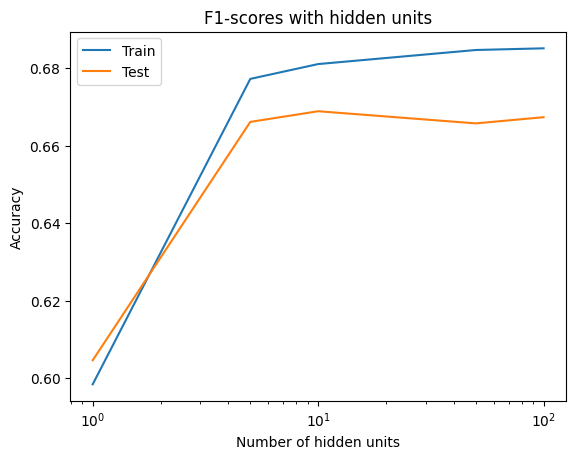

In [33]:
fig, ax = plt.subplots()

ax.plot(hidden_size_list, train_f1_score_list_uni, label="Train")
ax.plot(hidden_size_list, test_f1_score_list_uni, label="Test")

plt.legend()
plt.title('F1-scores with hidden units')
plt.xlabel('Number of hidden units')
plt.ylabel('Accuracy')
plt.xscale('log')

(c) Multilayer ANN

In [34]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_mul = []
test_f1_score_list_mul = []
for hidden_size in hidden_size_list:
    nn_mul = ANN(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_mul.train(X_train, y_train_oh, epochs=500)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_mul = nn_mul.predict(X_train)
    get_metric(y_train, y_pred_mul)

    f1_score = get_f1score(y_train, y_pred_mul)
    train_f1_score_list_mul.append(f1_score)

    print("Test scores:-")
    y_pred_mul = nn_mul.predict(X_test)
    get_metric(y_test, y_pred_mul)

    f1_score = get_f1score(y_test, y_pred_mul)
    test_f1_score_list_mul.append(f1_score)

Epoch 0/100 - Loss: 1.7278
Epoch 10/500 - Loss: 0.9674
Epoch 20/500 - Loss: 0.8475
Epoch 30/500 - Loss: 0.7980
Epoch 40/500 - Loss: 0.7707
Epoch 50/500 - Loss: 0.7537
Epoch 60/500 - Loss: 0.7420
Epoch 70/500 - Loss: 0.7336
Epoch 80/500 - Loss: 0.7271
Epoch 90/500 - Loss: 0.7219
Epoch 100/500 - Loss: 0.7177
Epoch 110/500 - Loss: 0.7141
Epoch 120/500 - Loss: 0.7109
Epoch 130/500 - Loss: 0.7082
Epoch 140/500 - Loss: 0.7057
Epoch 150/500 - Loss: 0.7034
Epoch 160/500 - Loss: 0.7013
Epoch 170/500 - Loss: 0.6993
Epoch 180/500 - Loss: 0.6974
Epoch 190/500 - Loss: 0.6957
Epoch 200/500 - Loss: 0.6940
Epoch 210/500 - Loss: 0.6924
Epoch 220/500 - Loss: 0.6908
Epoch 230/500 - Loss: 0.6893
Epoch 240/500 - Loss: 0.6878
Epoch 250/500 - Loss: 0.6863
Epoch 260/500 - Loss: 0.6849
Epoch 270/500 - Loss: 0.6835
Epoch 280/500 - Loss: 0.6820
Epoch 290/500 - Loss: 0.6806
Epoch 300/500 - Loss: 0.6792
Epoch 310/500 - Loss: 0.6778
Epoch 320/500 - Loss: 0.6763
Epoch 330/500 - Loss: 0.6749
Epoch 340/500 - Loss: 0.6

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

In [43]:
hidden_size = [512, 256, 128, 64]

nn_mul = ANN(1024, hidden_size, 5)

# try more epochs for larger net?
nn_mul.train(X_train, y_train_oh, epochs=500, tol=1e-6)

print(f"For hidden_size: {hidden_size}:")

print("Train scores:-")
y_pred_mul = nn_mul.predict(X_train)
get_metric(y_train, y_pred_mul)

f1_score = get_f1score(y_train, y_pred_mul)
train_f1_score_list_mul[-1] = (f1_score)

print("Test scores:-")
y_pred_mul = nn_mul.predict(X_test)
get_metric(y_test, y_pred_mul)

f1_score = get_f1score(y_test, y_pred_mul)
test_f1_score_list_mul[-1] = (f1_score)

Epoch 0/500 - Loss: 2.1557
Epoch 10/500 - Loss: 1.6095
Epoch 20/500 - Loss: 1.6086
Epoch 30/500 - Loss: 1.6071
Epoch 40/500 - Loss: 1.6039
Epoch 50/500 - Loss: 1.5940
Epoch 60/500 - Loss: 1.5159
Epoch 70/500 - Loss: 0.9851
Epoch 80/500 - Loss: 0.8415
Epoch 90/500 - Loss: 0.7859
Epoch 100/500 - Loss: 0.7588
Epoch 110/500 - Loss: 0.7438
Epoch 120/500 - Loss: 0.7344
Epoch 130/500 - Loss: 0.7276
Epoch 140/500 - Loss: 0.7223
Epoch 150/500 - Loss: 0.7179
Epoch 160/500 - Loss: 0.7139
Epoch 170/500 - Loss: 0.7103
Epoch 180/500 - Loss: 0.7069
Epoch 190/500 - Loss: 0.7035
Epoch 200/500 - Loss: 0.7002
Epoch 210/500 - Loss: 0.6967
Epoch 220/500 - Loss: 0.6931
Epoch 230/500 - Loss: 0.6892
Epoch 240/500 - Loss: 0.6850
Epoch 250/500 - Loss: 0.6803
Epoch 260/500 - Loss: 0.6753
Epoch 270/500 - Loss: 0.6699
Epoch 280/500 - Loss: 0.6644
Epoch 290/500 - Loss: 0.6590
Epoch 300/500 - Loss: 0.6538
Epoch 310/500 - Loss: 0.6485
Epoch 320/500 - Loss: 0.6431
Epoch 330/500 - Loss: 0.6373
Epoch 340/500 - Loss: 0.6

In [44]:
train_f1_score_list_mul

[0.7116672075896411,
 0.7468873701479575,
 0.7682536033570446,
 0.7693375887462051]

In [138]:
test_f1_score_list_mul

[0.69709076276345, 0.7373597347465938, 0.7593450543277083, 0.7593177677302272]

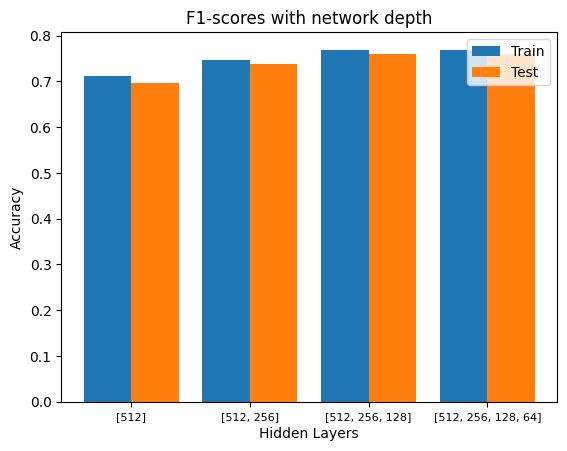

In [59]:
plt.bar(np.arange(4) - 0.2, train_f1_score_list_mul, 0.4, label="Train")
plt.bar(np.arange(4) + 0.2, test_f1_score_list_mul, 0.4, label="Test")

plt.xticks(np.arange(4), hidden_size_list)
plt.rc('xtick', labelsize=16)
plt.title('F1-scores with network depth')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.legend()

(d) Adaptive Learning Rate

In [61]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_adpt = []
test_f1_score_list_adpt = []
for hidden_size in hidden_size_list:
    nn_adpt = ANN(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_adpt.train(X_train, y_train_oh, epochs=1000, tol=1e-6, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_adpt = nn_adpt.predict(X_train)
    get_metric(y_train, y_pred_adpt)

    f1_score = get_f1score(y_train, y_pred_adpt)
    train_f1_score_list_adpt.append(f1_score)

    print("Test scores:-")
    y_pred_adpt = nn_adpt.predict(X_test)
    get_metric(y_test, y_pred_adpt)

    f1_score = get_f1score(y_test, y_pred_adpt)
    test_f1_score_list_adpt.append(f1_score)

Epoch 0/500 - Loss: 1.7218
Epoch 10/500 - Loss: 1.1375
Epoch 20/500 - Loss: 1.0258
Epoch 30/500 - Loss: 0.9720
Epoch 40/500 - Loss: 0.9384
Epoch 50/500 - Loss: 0.9147
Epoch 60/500 - Loss: 0.8968
Epoch 70/500 - Loss: 0.8825
Epoch 80/500 - Loss: 0.8708
Epoch 90/500 - Loss: 0.8610
Epoch 100/500 - Loss: 0.8526
Epoch 110/500 - Loss: 0.8452
Epoch 120/500 - Loss: 0.8387
Epoch 130/500 - Loss: 0.8329
Epoch 140/500 - Loss: 0.8277
Epoch 150/500 - Loss: 0.8230
Epoch 160/500 - Loss: 0.8187
Epoch 170/500 - Loss: 0.8147
Epoch 180/500 - Loss: 0.8111
Epoch 190/500 - Loss: 0.8077
Epoch 200/500 - Loss: 0.8046
Epoch 210/500 - Loss: 0.8017
Epoch 220/500 - Loss: 0.7989
Epoch 230/500 - Loss: 0.7964
Epoch 240/500 - Loss: 0.7939
Epoch 250/500 - Loss: 0.7917
Epoch 260/500 - Loss: 0.7895
Epoch 270/500 - Loss: 0.7875
Epoch 280/500 - Loss: 0.7856
Epoch 290/500 - Loss: 0.7837
Epoch 300/500 - Loss: 0.7820
Epoch 310/500 - Loss: 0.7803
Epoch 320/500 - Loss: 0.7787
Epoch 330/500 - Loss: 0.7772
Epoch 340/500 - Loss: 0.7

KeyboardInterrupt: 

In [139]:
test_f1_score_list_adpt

[]

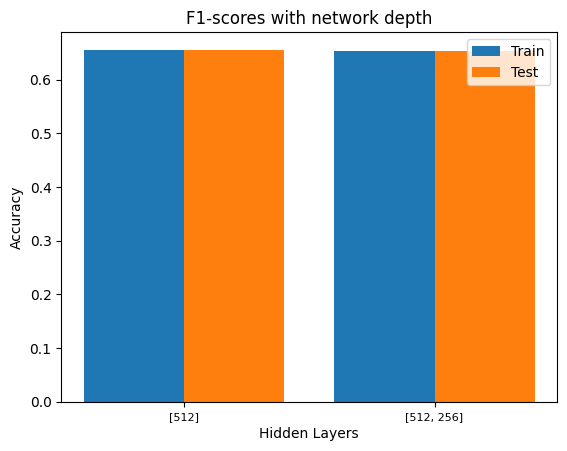

In [66]:
plt.bar(np.arange(2) - 0.2, train_f1_score_list_adpt, 0.4, label="Train")
plt.bar(np.arange(2) + 0.2, test_f1_score_list_adpt, 0.4, label="Test")

plt.xticks(np.arange(2), hidden_size_list[:2])
plt.rc('xtick', labelsize=4)
plt.title('F1-scores with network depth')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.legend()

Only ran 2 of 4 models above, doesn't seem to run well with a reduced learning rate.

In [67]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_adpt = []
test_f1_score_list_adpt = []
for hidden_size in hidden_size_list:
    nn_adpt = ANN(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_adpt.train(X_train, y_train_oh, epochs=1000, tol=1e-6, lr=0.5, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_adpt = nn_adpt.predict(X_train)
    get_metric(y_train, y_pred_adpt)

    f1_score = get_f1score(y_train, y_pred_adpt)
    train_f1_score_list_adpt.append(f1_score)

    print("Test scores:-")
    y_pred_adpt = nn_adpt.predict(X_test)
    get_metric(y_test, y_pred_adpt)

    f1_score = get_f1score(y_test, y_pred_adpt)
    test_f1_score_list_adpt.append(f1_score)

Epoch 0/1000 - Loss: 1.9116
Epoch 10/1000 - Loss: 0.7562
Epoch 20/1000 - Loss: 0.7148
Epoch 30/1000 - Loss: 0.6877
Epoch 40/1000 - Loss: 0.6657
Epoch 50/1000 - Loss: 0.6455
Epoch 60/1000 - Loss: 0.6267
Epoch 70/1000 - Loss: 0.6095
Epoch 80/1000 - Loss: 0.5945
Epoch 90/1000 - Loss: 0.5817
Epoch 100/1000 - Loss: 0.5707
Epoch 110/1000 - Loss: 0.5610
Epoch 120/1000 - Loss: 0.5520
Epoch 130/1000 - Loss: 0.5436
Epoch 140/1000 - Loss: 0.5356
Epoch 150/1000 - Loss: 0.5280
Epoch 160/1000 - Loss: 0.5207
Epoch 170/1000 - Loss: 0.5137
Epoch 180/1000 - Loss: 0.5070
Epoch 190/1000 - Loss: 0.5005
Epoch 200/1000 - Loss: 0.4942
Epoch 210/1000 - Loss: 0.4882
Epoch 220/1000 - Loss: 0.4825
Epoch 230/1000 - Loss: 0.4770
Epoch 240/1000 - Loss: 0.4717
Epoch 250/1000 - Loss: 0.4666
Epoch 260/1000 - Loss: 0.4617
Epoch 270/1000 - Loss: 0.4570
Epoch 280/1000 - Loss: 0.4524
Epoch 290/1000 - Loss: 0.4481
Epoch 300/1000 - Loss: 0.4438
Epoch 310/1000 - Loss: 0.4398
Epoch 320/1000 - Loss: 0.4358
Epoch 330/1000 - Loss

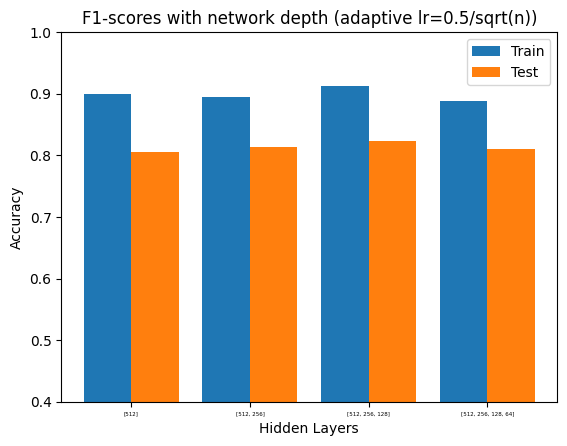

In [70]:
plt.bar(np.arange(4) - 0.2, train_f1_score_list_adpt, 0.4, label="Train")
plt.bar(np.arange(4) + 0.2, test_f1_score_list_adpt, 0.4, label="Test")

plt.xticks(np.arange(4), hidden_size_list)
plt.rc('xtick', labelsize=8)
plt.title('F1-scores with network depth (adaptive lr=0.5/sqrt(n))')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
plt.legend()

The learning rate used seems to work much better than with seed=0.01. All the models gain much better scores than before. We can see an increasing trend with network depth, as the f1 scores go from below 80 to 90+. But it falls off at [512,256,128,64], most likely because the learning rate we chose for this model was too large(can be inferred from the losses increasing near the epoch ends), that can be controlled by stopping our model when loss function increases. (Infact, the 3rd model also showed min loss = 0.1964)
Nevertheless, running for more than 500 epochs was useful since test results improve, suggesting an underfit earlier. The adaptive lr also helps deal with overfitting here.

(e) RelU Activation

In [12]:
def relu(x, clip=100, downscale=1):
    return np.where(x>0, np.where(x>clip, clip, x)*downscale, 0)

def relu_grad(x, clip=100, downscale=1):
    # subderivative at x=0 is set to 1(right limit)
    # subderivative at x=clip is set to 0(right limit)
    return np.where(x>=0, np.where(x>=clip, 0, downscale), 0)

In [39]:
class ANN_Relu(ANN):
    def fwd_prop(self, X):
        # list of layer outputs
        self.z = []
        self.actv = []

        A = X
        
        self.actv.append(A)
        self.z.append(np.eye(A.shape[0], A.shape[1]))        # to maintain same length

        for i in range(self.num_layers):
            Z = A@self.weights[i] + self.biases[i]
            self.z.append(Z)

            if i == self.num_layers-1:
                A = softmax(Z)
            else:
                A = relu(Z, clip=6.875)

            self.actv.append(A)

        # len(self.actv) == self.num_layers + 1 == len(self.weights) + 1
        return A
    
    def bwd_prop(self, y_true, lr):
        m = y_true.shape[0]
        y_pred = self.actv[-1]

        self.w_grad = []
        self.b_grad = []

        dZ = cross_entropy_grad_netk(y_true, y_pred)
        # dActv = softmax_grad(self.z[-1]).mean(axis=0)

        # print(dActv.shape)
        # print(dZ.shape)

        dB = np.mean(dZ, axis=0, keepdims=True)
        self.biases[-1] -= lr*dB
        self.b_grad.append(dB)

        dW = self.actv[-2].T@dZ/m


        # print(dW[0])
        # print(dW.shape)

        self.weights[-1] -= lr*dW
        self.w_grad.append(dW)

        for l in range(self.num_layers-2,-1,-1):
            dJd = dZ@self.weights[l+1].T
            dActv = relu_grad(self.z[l+1], clip=6.875).mean(axis=0)
    
            dZ = dJd*dActv
            dW = self.actv[l].T@dZ/m
            self.w_grad.append(dW)
            
            dB = np.mean(dZ, axis=0, keepdims=True)
            self.b_grad.append(dB)

            self.weights[l] -= lr*dW
            self.biases[l] -= lr*dB

        self.w_grad.reverse()
        self.b_grad.reverse()

        return self.w_grad, self.b_grad

In [14]:
import time

clip = 6.8 : within tol ; = 6.9 : overflow lol

In [40]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_relu = []
test_f1_score_list_relu = []
for hidden_size in hidden_size_list:
    t = time.time()
    nn_relu = ANN_Relu(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_relu.train(X_train, y_train_oh, epochs=500, tol=1e-6, lr=0.1, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_relu = nn_relu.predict(X_train)
    get_metric(y_train, y_pred_relu)

    f1_score = get_f1score(y_train, y_pred_relu)
    train_f1_score_list_relu.append(f1_score)

    print("Test scores:-")
    y_pred_relu = nn_relu.predict(X_test)
    get_metric(y_test, y_pred_relu)

    f1_score = get_f1score(y_test, y_pred_relu)
    test_f1_score_list_relu.append(f1_score)

    print(f"Time taken for {hidden_size}= {time.time()-t}")

Epoch 0/500 - Loss: 1.7712
Within tolerance = 1e-06
For hidden_size: [512]:
Train scores:-


c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       1.00      0.20      0.33     10000
         5.0       0.00      0.00      0.00         0

    accuracy                           0.20     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.20      0.33     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       1.00      0.19      0.32      1000
         5.0       0.00      0.00      0.00         0

    accuracy                           0.19      1000
   macro avg       0.20      0.04      0.06      1000
weighted avg       1.00      0.19      0.32      1000

Time tak

KeyboardInterrupt: 

In [104]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_relu = []
test_f1_score_list_relu = []
for hidden_size in hidden_size_list:
    t = time.time()
    nn_relu = ANN_Relu(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_relu.train(X_train, y_train_oh, epochs=500, tol=1e-6, lr=0.01, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_relu = nn_relu.predict(X_train)
    get_metric(y_train, y_pred_relu)

    f1_score = get_f1score(y_train, y_pred_relu)
    train_f1_score_list_relu.append(f1_score)

    print("Test scores:-")
    y_pred_relu = nn_relu.predict(X_test)
    get_metric(y_test, y_pred_relu)

    f1_score = get_f1score(y_test, y_pred_relu)
    test_f1_score_list_relu.append(f1_score)

    print(f"Time taken for {hidden_size}= {time.time()-t}")

Epoch 0/500 - Loss: 1.8558
Epoch 10/500 - Loss: 0.8375
Epoch 20/500 - Loss: 0.7892
Epoch 30/500 - Loss: 0.7675
Epoch 40/500 - Loss: 0.7544
Epoch 50/500 - Loss: 0.7455
Epoch 60/500 - Loss: 0.7390
Epoch 70/500 - Loss: 0.7340
Epoch 80/500 - Loss: 0.7300
Epoch 90/500 - Loss: 0.7266
Epoch 100/500 - Loss: 0.7238
Epoch 110/500 - Loss: 0.7214
Epoch 120/500 - Loss: 0.7192
Epoch 130/500 - Loss: 0.7173
Epoch 140/500 - Loss: 0.7156
Epoch 150/500 - Loss: 0.7141
Epoch 160/500 - Loss: 0.7127
Epoch 170/500 - Loss: 0.7114
Epoch 180/500 - Loss: 0.7102
Epoch 190/500 - Loss: 0.7090
Epoch 200/500 - Loss: 0.7080
Epoch 210/500 - Loss: 0.7070
Epoch 220/500 - Loss: 0.7061
Epoch 230/500 - Loss: 0.7052
Epoch 240/500 - Loss: 0.7044
Epoch 250/500 - Loss: 0.7036
Epoch 260/500 - Loss: 0.7029
Epoch 270/500 - Loss: 0.7022
Epoch 280/500 - Loss: 0.7015
Epoch 290/500 - Loss: 0.7008
Epoch 300/500 - Loss: 0.7002
Epoch 310/500 - Loss: 0.6996
Epoch 320/500 - Loss: 0.6990
Epoch 330/500 - Loss: 0.6984
Epoch 340/500 - Loss: 0.6

Reduced the learning rate back to 0.01 because it was exploding the weights(presumably because ReLU isn't bound like sigmoid). Also, reduced the epoch limit back to 500 since ReLU should ideally take lesser time to converge. 

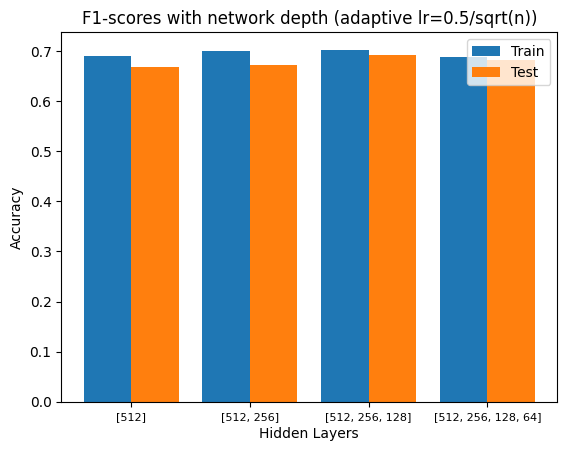

In [107]:
plt.bar(np.arange(4) - 0.2, train_f1_score_list_relu, 0.4, label="Train")
plt.bar(np.arange(4) + 0.2, test_f1_score_list_relu, 0.4, label="Test")

plt.xticks(np.arange(4), hidden_size_list)
plt.rc('xtick', labelsize=8)
plt.title('F1-scores with network depth (adaptive lr=0.5/sqrt(n))')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# fig, ax = plt.subplots()

# ax.plot(hidden_size_list, train_f1_score_list_relu, label="Train")
# ax.plot(hidden_size_list, test_f1_score_list_relu, label="Test")

# plt.title('F1-scores with network depth (adaptive lr=0.5/sqrt(n))')
# plt.xlabel('Network depth')
# plt.ylabel('F1-score')

We see f1-scores around the 70% mark, improving faintly with network depth. The last model converges before 500 epochs as the error falls into the tolerance limit, making it run for almost half the time of the previous one, while giving almost the same results.

Compared to the sigmoid-based models, the relu-based models do infact seem to perform better If we compare results with same learning seed = 0.01, there is an increase of around 4% over their sigmoid counterparts. It would be interesting to see the performance of relu model with higher lr(need to figure out a solution to blowing-up gradients, probably tweaking units to have falling weights https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network)

In [116]:
asa = np.random.randn(2,5)
wasa = asa - asa.max(axis=1, keepdims=True)
print(asa)
print(wasa)

[[-0.53101805 -1.02723312  0.16240695 -0.39949213 -1.44761306]
 [ 0.20130473  0.2859648   1.12963881  0.46036328  2.20221144]]
[[-0.693425   -1.18964007  0.         -0.56189909 -1.61002001]
 [-2.00090671 -1.91624664 -1.07257263 -1.74184816  0.        ]]


In [119]:
print(softmax(asa))
print(softmax(wasa))

[[0.19418108 0.1182234  0.38847008 0.22147663 0.0776488 ]
 [0.07513088 0.08176847 0.19010295 0.09734781 0.55564989]]
[[0.19418108 0.1182234  0.38847008 0.22147663 0.0776488 ]
 [0.07513088 0.08176847 0.19010295 0.09734781 0.55564989]]


One solution here seems to subtract the max value so that softmax layer doesn't overflow. (Edit: Other layers do, still might be a potential solution)

In [135]:
class ANN_Relu_Scale(ANN_Relu):
    def fwd_prop(self, X):
        # list of layer outputs
        self.z = []
        self.actv = []

        A = X
        
        self.actv.append(A)
        self.z.append(np.eye(A.shape[0], A.shape[1]))        # to maintain same length

        for i in range(self.num_layers):
            Z = A@self.weights[i] + self.biases[i]
            self.z.append(Z)

            if i == self.num_layers-1:
                # Z_modifive = Z - Z.max(axis=1, keepdims=True)
                A = softmax(Z)
                # A = softmax(Z_modifive)
            else:
                # also in previous layers?
                # Z_modifive = Z - Z.max(axis=1, keepdims=True)
                A = relu(Z, downscale=1e-2)

            self.actv.append(A)

        # len(self.actv) == self.num_layers + 1 == len(self.weights) + 1
        return A
    
    def bwd_prop(self, y_true, lr):
        m = y_true.shape[0]
        y_pred = self.actv[-1]

        self.w_grad = []
        self.b_grad = []

        dZ = cross_entropy_grad_netk(y_true, y_pred)
        # dActv = softmax_grad(self.z[-1]).mean(axis=0)

        # print(dActv.shape)
        # print(dZ.shape)

        dB = np.mean(dZ, axis=0, keepdims=True)
        self.biases[-1] -= lr*dB
        self.b_grad.append(dB)

        dW = self.actv[-2].T@dZ/m


        # print(dW[0])
        # print(dW.shape)

        self.weights[-1] -= lr*dW
        self.w_grad.append(dW)

        for l in range(self.num_layers-2,-1,-1):
            dJd = dZ@self.weights[l+1].T
            dActv = relu_grad(self.z[l+1], downscale=1e-2).mean(axis=0)
    
            dZ = dJd*dActv
            dW = self.actv[l].T@dZ/m
            self.w_grad.append(dW)
            
            dB = np.mean(dZ, axis=0, keepdims=True)
            self.b_grad.append(dB)

            self.weights[l] -= lr*dW
            self.biases[l] -= lr*dB

        self.w_grad.reverse()
        self.b_grad.reverse()

        return self.w_grad, self.b_grad

Current relu uses a downscale factor of 0.01 (tried others, 0.1 blows up and 0.001 vanishes).

In [136]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list_relu_s = []
test_f1_score_list_relu_s = []
for hidden_size in hidden_size_list:
    t = time.time()
    nn_relu = ANN_Relu_Scale(1024, hidden_size, 5)

    # try more epochs for larger net?
    nn_relu.train(X_train, y_train_oh, epochs=500, tol=1e-6, lr=0.5, adaptive=True)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_relu = nn_relu.predict(X_train)
    get_metric(y_train, y_pred_relu)

    f1_score = get_f1score(y_train, y_pred_relu)
    train_f1_score_list_relu_s.append(f1_score)

    print("Test scores:-")
    y_pred_relu = nn_relu.predict(X_test)
    get_metric(y_test, y_pred_relu)

    f1_score = get_f1score(y_test, y_pred_relu)
    test_f1_score_list_relu_s.append(f1_score)

    print(f"Time taken for {hidden_size}= {time.time()-t}")

Epoch 0/500 - Loss: 1.6093
Epoch 10/500 - Loss: 1.1942
Epoch 20/500 - Loss: 1.0015
Epoch 30/500 - Loss: 0.9306
Epoch 40/500 - Loss: 0.8907
Epoch 50/500 - Loss: 0.8644
Epoch 60/500 - Loss: 0.8456
Epoch 70/500 - Loss: 0.8312
Epoch 80/500 - Loss: 0.8199
Epoch 90/500 - Loss: 0.8107
Epoch 100/500 - Loss: 0.8031
Epoch 110/500 - Loss: 0.7967
Epoch 120/500 - Loss: 0.7912
Epoch 130/500 - Loss: 0.7864
Epoch 140/500 - Loss: 0.7822
Epoch 150/500 - Loss: 0.7784
Epoch 160/500 - Loss: 0.7751
Epoch 170/500 - Loss: 0.7721
Epoch 180/500 - Loss: 0.7693
Epoch 190/500 - Loss: 0.7668
Epoch 200/500 - Loss: 0.7645
Epoch 210/500 - Loss: 0.7624
Epoch 220/500 - Loss: 0.7604
Epoch 230/500 - Loss: 0.7586
Epoch 240/500 - Loss: 0.7569
Epoch 250/500 - Loss: 0.7553
Epoch 260/500 - Loss: 0.7538
Epoch 270/500 - Loss: 0.7524
Epoch 280/500 - Loss: 0.7511
Epoch 290/500 - Loss: 0.7498
Epoch 300/500 - Loss: 0.7486
Epoch 310/500 - Loss: 0.7475
Epoch 320/500 - Loss: 0.7464
Epoch 330/500 - Loss: 0.7454
Epoch 340/500 - Loss: 0.7

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.21      0.35     10000

    accuracy                           0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.19      0.32      1000

    accuracy                           0.19      1000
   macro avg       0.20      0.04      0.06      1000
weighted avg       1.00      0.19      0.32      1000

Time tak

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.21      0.35     10000

    accuracy                           0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.19      0.32      1000

    accuracy                           0.19      1000
   macro avg       0.20      0.04      0.06      1000
weighted avg       1.00      0.19      0.32      1000

Time tak

c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DevTools\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefin

In [137]:
print(train_f1_score_list_relu_s)
print(test_f1_score_list_relu_s)

[0.6682746612988908, 0.06917541973368621, 0.06917541973368621, 0.06917541973368621]
[0.6633024260773688, 0.06301600673967986, 0.06301600673967986, 0.06301600673967986]


Only the single layered model runs properly on this downscaled relu function.

(f) MLP Classifier

In [108]:
from sklearn.neural_network import MLPClassifier

In [109]:
hidden_size_list = [[512],[512,256],[512,256,128],[512,256,128,64]]

train_f1_score_list = []
test_f1_score_list = []

for hidden_size in hidden_size_list:
    mlp_clf = MLPClassifier(hidden_layer_sizes=hidden_size, activation='relu', solver='sgd', batch_size=32, alpha=0, learning_rate='invscaling')

    mlp_clf.fit(X_train, y_train)

    print(f"For hidden_size: {hidden_size}:")

    print("Train scores:-")
    y_pred_mlp = mlp_clf.predict(X_train)
    get_metric(y_train, y_pred_mlp)

    f1_score = get_f1score(y_train, y_pred_mlp)
    train_f1_score_list.append(f1_score)

    print("Test scores:-")
    y_pred_mlp = mlp_clf.predict(X_test)
    get_metric(y_test, y_pred_mlp)

    f1_score = get_f1score(y_test, y_pred_mlp)
    test_f1_score_list.append(f1_score)

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.91      0.71      0.79      2523
         2.0       0.45      0.52      0.48      1703
         3.0       0.34      0.46      0.39      1448
         4.0       0.34      0.45      0.39      1503
         5.0       0.82      0.61      0.70      2823

    accuracy                           0.57     10000
   macro avg       0.57      0.55      0.55     10000
weighted avg       0.64      0.57      0.59     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.89      0.73      0.80       277
         2.0       0.40      0.49      0.44       162
         3.0       0.32      0.45      0.37       141
         4.0       0.34      0.40      0.37       161
         5.0       0.78      0.56      0.65       259

    accuracy                           0.56      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.61 

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512, 256]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.90      0.78      0.83      2267
         2.0       0.54      0.58      0.56      1823
         3.0       0.43      0.47      0.45      1791
         4.0       0.37      0.45      0.40      1638
         5.0       0.75      0.63      0.68      2481

    accuracy                           0.60     10000
   macro avg       0.60      0.58      0.59     10000
weighted avg       0.62      0.60      0.61     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.87      0.80      0.84       250
         2.0       0.51      0.56      0.53       179
         3.0       0.40      0.48      0.44       167
         4.0       0.37      0.40      0.39       171
         5.0       0.68      0.55      0.60       233

    accuracy                           0.58      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512, 256, 128]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.89      0.82      0.86      2143
         2.0       0.62      0.62      0.62      1981
         3.0       0.46      0.49      0.47      1816
         4.0       0.37      0.45      0.41      1653
         5.0       0.74      0.64      0.69      2407

    accuracy                           0.62     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.64      0.62      0.63     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.88      0.84      0.86       240
         2.0       0.57      0.59      0.58       193
         3.0       0.47      0.51      0.49       183
         4.0       0.40      0.44      0.42       168
         5.0       0.71      0.61      0.66       216

    accuracy                           0.61      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg  

c:\DevTools\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For hidden_size: [512, 256, 128, 64]:
Train scores:-
              precision    recall  f1-score   support

         1.0       0.89      0.84      0.87      2098
         2.0       0.63      0.65      0.64      1909
         3.0       0.49      0.51      0.50      1871
         4.0       0.41      0.47      0.44      1773
         5.0       0.75      0.66      0.70      2349

    accuracy                           0.64     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.65      0.64      0.64     10000

Test scores:-
              precision    recall  f1-score   support

         1.0       0.90      0.87      0.88       238
         2.0       0.59      0.63      0.61       183
         3.0       0.50      0.54      0.52       183
         4.0       0.46      0.44      0.45       194
         5.0       0.70      0.64      0.67       202

    accuracy                           0.64      1000
   macro avg       0.63      0.63      0.63      1000
weighted a

Text(0, 0.5, 'Accuracy')

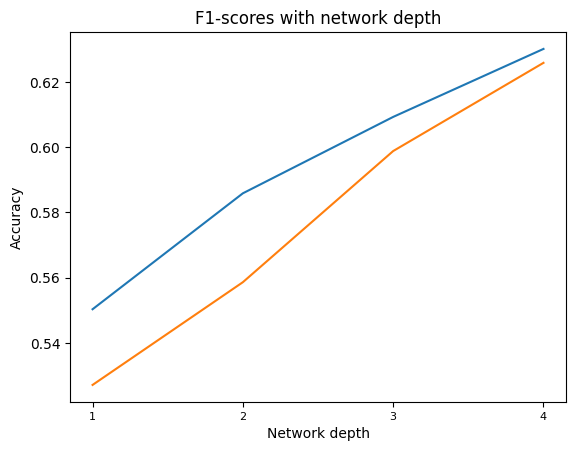

In [142]:
fig, ax = plt.subplots()

ax.plot(np.arange(1,5), train_f1_score_list, label="Train")
ax.plot(np.arange(1,5), test_f1_score_list, label="Test")

plt.title('F1-scores with network depth')
plt.xlabel('Network depth')
plt.xticks(np.arange(1,5))
plt.ylabel('Accuracy')